# Function 1: 2D Radiation Detection

Explore the initial 10 (x, y) points, visualize the landscape, and suggest the next input to submit.

- 2D, sparse signal (only proximity yields non-zero reading).
- One hotspot; goal is to find it with limited queries.

**What this notebook does:** Loads the initial 10 observations for Function 1 (2D radiation detection), infers bounds and a simple distance-based landscape, fits Gaussian Process (GP) models with RBF and Matérn kernels, and suggests the next point to evaluate using several acquisition functions (Expected Improvement, UCB, PI, Thompson Sampling, Entropy Search). A baseline “exploit” strategy (small random step from the current best) is also shown for comparison. Use the GP-based suggestions or the baseline depending on whether you want Bayesian optimization or a simple heuristic.

### Write safety — what is read-only vs writable

- **Never written to (read-only):**
  - `initial_data/` — challenge data; this notebook and `load_challenge_data` only **read** from here. No code in this repo writes to `initial_data/`.
- **Written only when you enable the flag:**
  - Plot files (e.g. `function_1_observations_and_distance_contour`, `function_1_3d_surface_distance_colour`, `function_1_gp_three_kernels`) — only if **IF_EXPORT_PLOT = True**. Save location: **PLOT_EXPORT_DIR** (default `data/results`). Format and DPI: **DEFAULT_EXPORT_FORMAT**, **DEFAULT_EXPORT_DPI** (from utils).
  - `data/submissions/function_1/next_input.npy` and `next_input_portal.txt` (portal format: 6 decimals, hyphens, no spaces) — only if **IF_EXPORT_QUERIES = True**
  - `data/problems/function_1/inputs.npy` and `outputs.npy` — only if **IF_APPEND_DATA = True** (append cell). This is your local copy (initial + appended points); re-running the append cell with the same new point will overwrite these two files with the same content (one more row). To avoid overwriting your accumulated data, keep **IF_APPEND_DATA = False** until you have new portal feedback to add.

**Summary:** With all flags `False`, running the notebook does not write any files. Turn only the flags you need to `True` for this run.

## 1. Setup and load data (read-only from initial_data)

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")


# Project root: works whether you run from repo root or from notebooks/
repo_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

from src.utils.load_challenge_data import (
    load_function_data, 
    assert_not_under_initial_data
)
from src.optimizers.bayesian.acquisition_functions import (
    entropy_search,
    expected_improvement,
    probability_of_improvement,
    thompson_sampling_sample,
    upper_confidence_bound,
)
from src.utils.plot_utilities import (
    add_colorbar,
    style_axis,
    style_axis_3d,
    style_legend,
    DEFAULT_FONT_SIZE_AXIS,
    DEFAULT_FONT_SIZE_TITLES,
    DEFAULT_EXPORT_DPI,
    DEFAULT_EXPORT_FORMAT,
)

# --- Plot options; font/export defaults from utils (DEFAULT_*) ---
IF_SHOW_PLOT = True
IF_EXPORT_PLOT = False
PLOT_EXPORT_DIR = repo_root / "data" / "results"

IF_EXPORT_QUERIES = False
IF_APPEND_DATA = False

# Set seed for reproducibility
np.random.seed(42)

In [3]:
# Load: use local appended data if available, else initial_data (read-only)
local_dir = repo_root / "data" / "problems" / "function_1"
local_inputs = local_dir / "inputs.npy"
local_outputs = local_dir / "outputs.npy"
if local_inputs.exists() and local_outputs.exists():
    X = np.load(local_inputs)
    y = np.load(local_outputs)
    if y.ndim > 1:
        y = y.squeeze()
    print("Loaded from local data (initial + appended):", local_dir)
else:
    X, y = load_function_data(function_id=1)
    print("Loaded from initial_data (read-only). Run 'Append data' after portal feedback to build local dataset.")
print('Dataset info:')
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X max value: {X.max():.6f}")
print(f"X min value: {X.min():.6f}")
print(f"y max value: {y.max():.6f}")
print(f"y min value: {y.min():.6f}")

Loaded from initial_data (read-only). Run 'Append data' after portal feedback to build local dataset.
Dataset info:
X shape: (10, 2)
y shape: (10,)
X max value: 0.883890
X min value: 0.078723
y max value: 0.000000
y min value: -0.003606


## 2. Visualize the 10 initial points

**Convention (no mix-up):** `X` has shape (n, 2) with columns **x_1** = `X[:, 0]` and **x_2** = `X[:, 1]`. **y** is the objective value (scalar per row). All 2D plots: horizontal = x_1, vertical = x_2. 3D: floor = (x_1, x_2), height = y.

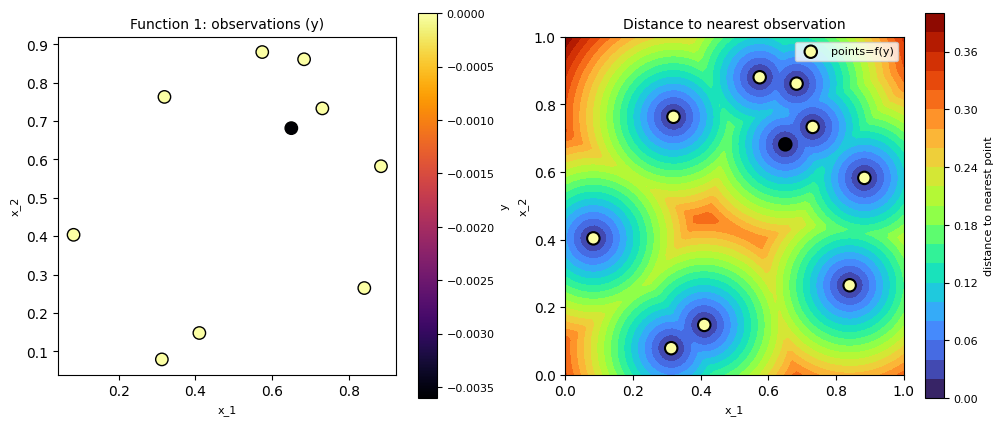

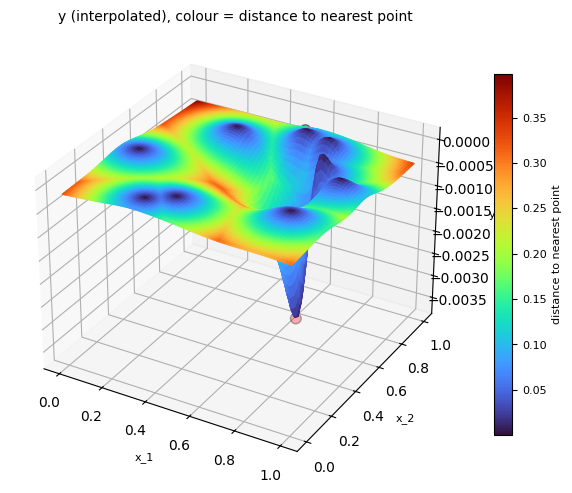

In [4]:
# Grid for contour: distance from each point to nearest observation
n_grid = 80
x1g = np.linspace(0, 1, n_grid)
x2g = np.linspace(0, 1, n_grid)
X1g, X2g = np.meshgrid(x1g, x2g)
grid_pts = np.column_stack([X1g.ravel(), X2g.ravel()])
# Distance from each grid point to nearest of X (L2, numpy only)
diff = grid_pts[:, None, :] - X[None, :, :]  # (n_grid^2, n_obs, 2)
dists = np.sqrt((diff ** 2).sum(axis=2))
min_dist = np.min(dists, axis=1).reshape(X1g.shape)

# Interpolate y onto grid (IDW) for 3D surface
dist_gx = np.sqrt(((grid_pts[:, None, :] - X[None, :, :]) ** 2).sum(axis=2)) + 1e-12
w = 1.0 / (dist_gx ** 2)
y_grid = (w * y[None, :]).sum(axis=1) / w.sum(axis=1)
Y_grid = y_grid.reshape(X1g.shape)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# Left: scatter of observations colored by y
sc = ax1.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap="inferno", edgecolors="k")
add_colorbar(sc, ax=ax1, label="y", font_size_axis=DEFAULT_FONT_SIZE_AXIS)
style_axis(ax1, xlabel="x_1", ylabel="x_2", title="Function 1: observations (y)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
ax1.set_aspect("equal")

# Right: contour of distance to nearest point
cf = ax2.contourf(X1g, X2g, min_dist, levels=22, cmap="turbo")
add_colorbar(cf, ax=ax2, label="distance to nearest point", font_size_axis=DEFAULT_FONT_SIZE_AXIS)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap="inferno", edgecolors="black", linewidths=1.5, zorder=2, label="points=f(y)")
style_axis(ax2, xlabel="x_1", ylabel="x_2", title="Distance to nearest observation", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
ax2.set_aspect("equal")
style_legend(ax2, loc="upper right", font_size_axis=DEFAULT_FONT_SIZE_AXIS)

# For second figure (3D): norm and mappable for distance colour
norm_dist = plt.Normalize(min_dist.min(), min_dist.max())
sm = cm.ScalarMappable(cmap=cm.turbo, norm=norm_dist)
sm.set_array(min_dist)

if IF_SHOW_PLOT or IF_EXPORT_PLOT:
    # Second figure: 3D plot only (standalone; created for display and/or export)
    fig2 = plt.figure(figsize=(7, 5))
    ax3b = fig2.add_subplot(111, projection="3d")
    facecolors = cm.turbo(norm_dist(min_dist))[:-1, :-1]
    ax3b.plot_surface(X1g, X2g, Y_grid, facecolors=facecolors, rstride=1, cstride=1, shade=False)
    ax3b.scatter(X[:, 0], X[:, 1], y, c="red", s=60, edgecolors="k", depthshade=True)
    style_axis_3d(ax3b, xlabel="x_1", ylabel="x_2", zlabel="y", title="y (interpolated), colour = distance to nearest point", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    add_colorbar(sm, ax=ax3b, label="distance to nearest point", font_size_axis=DEFAULT_FONT_SIZE_AXIS, shrink=0.8)

plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path_2d = out_dir / f"function_1_observations_and_distance_contour.{DEFAULT_EXPORT_FORMAT}"
    fig.savefig(out_path_2d, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path_2d)
    out_path_3d = out_dir / f"function_1_3d_surface_distance_colour.{DEFAULT_EXPORT_FORMAT}"
    fig2.savefig(out_path_3d, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path_3d)
if IF_SHOW_PLOT:
    plt.show()

## 3. Suggest next point to submit, using Baysian Optimization Methodology

### 3.1 The Probabilistic Surrogate Models

 * **Gaussian Process (GP)** — we compare three kernel choices below; each gives a different prior over functions and uncertainty:

    - **RBF kernel** — Smooth, infinitely differentiable prior; single length-scale. *Differs:* no explicit noise term (fixed small `alpha` for stability).

    - **Matérn kernel (ν=1.5)** — Less smooth than RBF; allows rougher, more "wiggly" surfaces. *Differs:* better when the true function has sharper changes or only finitely many derivatives.

    - **RBF + WhiteKernel** — Same smoothness as RBF but adds a separate noise term. *Differs:* explicitly models observation noise; uncertainty splits into noise vs interpolation.

 * **Random Forest (RF)** — *Different approach:* non-parametric ensemble of trees; no Gaussian prior or native uncertainty (would need e.g. quantile regression for uncertainty). Not implemented below; listed as an alternative surrogate family.


In [5]:
# Gaussian Process Regression (run after visualization cell so X1g, grid_pts exist)
# Coefficients: ConstantKernel = signal variance (output scale); length_scale = correlation length (≈ 0.5 reasonable for [0,1]^2);
#   nu (Matérn) = smoothness (1.5 = once differentiable); WhiteKernel = observation noise variance; alpha = diagonal jitter for numerical stability.
kernel_RBF = ConstantKernel(1.0) * RBF(length_scale=0.5)
gp_RBF = GaussianProcessRegressor(kernel=kernel_RBF, alpha=1e-6)
gp_RBF.fit(X, y)
mu_gp_RBF, sigma_gp_RBF = gp_RBF.predict(grid_pts, return_std=True)
mu_gp_RBF = mu_gp_RBF.reshape(X1g.shape)
sigma_gp_RBF = sigma_gp_RBF.reshape(X1g.shape)

# Matern: same length_scale; nu=1.5 gives rougher prior than RBF
kernel_Matern = ConstantKernel(1.0) * Matern(length_scale=0.5, nu=1.5)
gp_Matern = GaussianProcessRegressor(kernel=kernel_Matern, alpha=1e-6)
gp_Matern.fit(X, y)
mu_gp_Matern, sigma_gp_Matern = gp_Matern.predict(grid_pts, return_std=True)
mu_gp_Matern = mu_gp_Matern.reshape(X1g.shape)
sigma_gp_Matern = sigma_gp_Matern.reshape(X1g.shape)

# RBF + WhiteKernel: noise_level=1e-6 lets the GP fit learn a small observation noise (or keep it tiny if data are noiseless)
kernel_RBF_noise = ConstantKernel(1.0) * RBF(length_scale=0.5) + WhiteKernel(noise_level=1e-6)
gp_RBF_noise = GaussianProcessRegressor(kernel=kernel_RBF_noise, alpha=1e-6)
gp_RBF_noise.fit(X, y)
mu_gp_RBF_noise, sigma_gp_RBF_noise = gp_RBF_noise.predict(grid_pts, return_std=True)
mu_gp_RBF_noise = mu_gp_RBF_noise.reshape(X1g.shape)
sigma_gp_RBF_noise = sigma_gp_RBF_noise.reshape(X1g.shape)


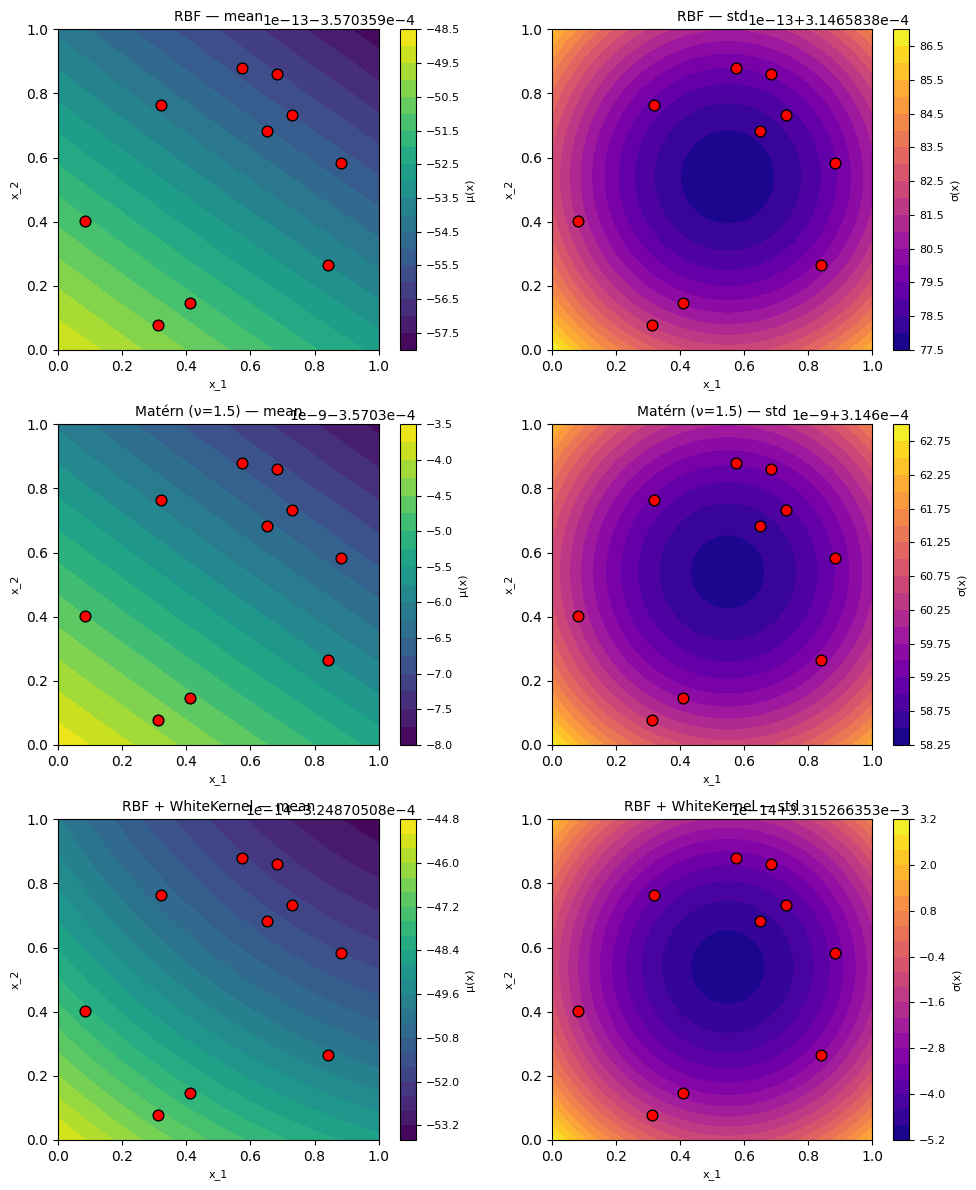

In [6]:
# Plot all three GPs: mean (left) and std (right) per kernel
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
kernels_info = [
    (mu_gp_RBF, sigma_gp_RBF, "RBF"),
    (mu_gp_Matern, sigma_gp_Matern, "Matérn (ν=1.5)"),
    (mu_gp_RBF_noise, sigma_gp_RBF_noise, "RBF + WhiteKernel"),
]
for i, (mu, sig, name) in enumerate(kernels_info):
    ax_mu, ax_sig = axes[i, 0], axes[i, 1]
    cf1 = ax_mu.contourf(X1g, X2g, mu, levels=20, cmap="viridis")
    add_colorbar(cf1, ax=ax_mu, label="μ(x)", font_size_axis=DEFAULT_FONT_SIZE_AXIS)
    ax_mu.scatter(X[:, 0], X[:, 1], c="red", s=60, edgecolors="k")
    style_axis(ax_mu, xlabel="x_1", ylabel="x_2", title=f"{name} — mean", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax_mu.set_aspect("equal")
    cf2 = ax_sig.contourf(X1g, X2g, sig, levels=20, cmap="plasma")
    add_colorbar(cf2, ax=ax_sig, label="σ(x)", font_size_axis=DEFAULT_FONT_SIZE_AXIS)
    ax_sig.scatter(X[:, 0], X[:, 1], c="red", s=60, edgecolors="k")
    style_axis(ax_sig, xlabel="x_1", ylabel="x_2", title=f"{name} — std", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax_sig.set_aspect("equal")
axes[0, 0].set_xlabel("x_1", fontsize=DEFAULT_FONT_SIZE_AXIS)
axes[1, 0].set_xlabel("x_1", fontsize=DEFAULT_FONT_SIZE_AXIS)
axes[2, 0].set_xlabel("x_1", fontsize=DEFAULT_FONT_SIZE_AXIS)
axes[2, 1].set_xlabel("x_1", fontsize=DEFAULT_FONT_SIZE_AXIS)
plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"function_1_gp_three_kernels.{DEFAULT_EXPORT_FORMAT}"
    fig.savefig(out_path, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path)
if IF_SHOW_PLOT:
    plt.show()  

### 3.2 The Acquisition Functions $\alpha$(x)

* Expected Improvment (EI)

* Upper Confidence Bound (UCB)

* Probability of Improvment (PI)

* Thomson Sampling

* Entropy Search

In [7]:
# ACQUISITION FUNCTION(s)

# --- EXPECTED IMPROVEMENT: EI = E[max(f(x) − f(x⁺), 0)] ---
#   * Using the RBF kernel and xi = 0.01
y_best_EI = y.max()  # best observed value so far (EI baseline)
EI_RBF = expected_improvement(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=0.01)  # (mu, sigma, y_best); no grid_pts
x_best_EI_RBF = grid_pts[np.argmax(EI_RBF)]  # grid point with highest EI = next point to evaluate
#   * Using the Matérn kernel and xi = 0.01
EI_Matern = expected_improvement(mu_gp_Matern, sigma_gp_Matern, y_best_EI, xi=0.01)  # (mu, sigma, y_best); no grid_pts
x_best_EI_Matern = grid_pts[np.argmax(EI_Matern)]  # grid point with highest EI = next point to evaluate 


# --- UPPER CONFIDENCE BOUND: UCB = μ(x) + κσ(x) ---
#   * Using the RBF kernel and κ = 0.5
UCB_RBF = upper_confidence_bound(mu_gp_RBF, sigma_gp_RBF, kappa=0.5)  # UCB = μ(x) + κσ(x); no y_best
x_best_UCB_RBF = grid_pts[np.argmax(UCB_RBF)]  # grid point with highest UCB = next point to evaluate
#   * Using the Matérn kernel and κ = 0.5
UCB_Matern = upper_confidence_bound(mu_gp_Matern, sigma_gp_Matern, kappa=0.5)  # UCB = μ(x) + κσ(x); no y_best
x_best_UCB_Matern = grid_pts[np.argmax(UCB_Matern)]  # grid point with highest UCB = next point to evaluate


# --- PROBABILITY OF IMPROVEMENT: PI = P(f(x) > f(x⁺)) ---
#   * Using the RBF kernel and xi = 0.01
PI_RBF = probability_of_improvement(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=0.01)  # (mu, sigma, y_best); no grid_pts
x_best_PI_RBF = grid_pts[np.argmax(PI_RBF)]  # grid point with highest PI = next point to evaluate
#   * Using the Matérn kernel and xi = 0.01
PI_Matern = probability_of_improvement(mu_gp_Matern, sigma_gp_Matern, y_best_EI, xi=0.01)  # (mu, sigma, y_best); no grid_pts
x_best_PI_Matern = grid_pts[np.argmax(PI_Matern)]  # grid point with highest PI = next point to evaluate


# --- THOMPSON SAMPLING: sample from posterior, then maximize the sample ---
#   * Using the RBF kernel (returns one sample per grid point; argmax → next point)
sample_thompson_RBF = thompson_sampling_sample(mu_gp_RBF, sigma_gp_RBF)  # (mu, sigma); optional rng=
x_thomson_RBF = grid_pts[np.argmax(sample_thompson_RBF)]
#   * Using the Matérn kernel
sample_thompson_Matern = thompson_sampling_sample(mu_gp_Matern, sigma_gp_Matern)
x_thomson_Matern = grid_pts[np.argmax(sample_thompson_Matern)]


# --- ENTROPY SEARCH: proxy −σ(x) (favor reducing uncertainty) ---
#   * Using the RBF kernel (entropy_search returns acquisition values; argmax → next point)
ES_RBF = entropy_search(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=0.01)
x_entropy_RBF = grid_pts[np.argmax(ES_RBF)]
#   * Using the Matérn kernel
ES_Matern = entropy_search(mu_gp_Matern, sigma_gp_Matern, y_best_EI, xi=0.01)
x_entropy_Matern = grid_pts[np.argmax(ES_Matern)]


print(f'Next point (EI) with RBF kernel and xi = 0.01: x_best_EI = ({x_best_EI_RBF[0]:.2f}, {x_best_EI_RBF[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (EI) with Matérn kernel and xi = 0.01: x_best_EI = ({x_best_EI_Matern[0]:.2f}, {x_best_EI_Matern[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (UCB) with RBF kernel and κ = 0.5: x_best_UCB = ({x_best_UCB_RBF[0]:.2f}, {x_best_UCB_RBF[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (UCB) with Matérn kernel and κ = 0.5: x_best_UCB = ({x_best_UCB_Matern[0]:.2f}, {x_best_UCB_Matern[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (PI) with RBF kernel and xi = 0.01: x_best_PI = ({x_best_PI_RBF[0]:.2f}, {x_best_PI_RBF[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (PI) with Matérn kernel and xi = 0.01: x_best_PI = ({x_best_PI_Matern[0]:.2f}, {x_best_PI_Matern[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (Thomson) with RBF kernel: x_thomson = ({x_thomson_RBF[0]:.2f}, {x_thomson_RBF[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (Thomson) with Matérn kernel: x_thomson = ({x_thomson_Matern[0]:.2f}, {x_thomson_Matern[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (Entropy) with RBF kernel: x_entropy = ({x_entropy_RBF[0]:.2f}, {x_entropy_RBF[1]:.2f}) | current best observed y = {y_best_EI:.2f}')
print(f'Next point (Entropy) with Matérn kernel: x_entropy = ({x_entropy_Matern[0]:.2f}, {x_entropy_Matern[1]:.2f}) | current best observed y = {y_best_EI:.2f}')

# Kernel selection sensitivity: Delta = (RBF suggestion) - (Matern suggestion)
delta_EI = x_best_EI_RBF - x_best_EI_Matern
delta_UCB = x_best_UCB_RBF - x_best_UCB_Matern
delta_PI = x_best_PI_RBF - x_best_PI_Matern
delta_Thompson = x_thomson_RBF - x_thomson_Matern
delta_Entropy = x_entropy_RBF - x_entropy_Matern
print('\nKernel selection sensitivity (Delta = RBF - Matern):')
print(f'  EI:       Delta: x_1 = {delta_EI[0]:.2f}, x_2 = {delta_EI[1]:.2f}')
print(f'  UCB:      Delta: x_1 = {delta_UCB[0]:.2f}, x_2 = {delta_UCB[1]:.2f}')
print(f'  PI:       Delta: x_1 = {delta_PI[0]:.2f}, x_2 = {delta_PI[1]:.2f}')
print(f'  Thompson: Delta: x_1 = {delta_Thompson[0]:.2f}, x_2 = {delta_Thompson[1]:.2f}')
print(f'  Entropy:  Delta: x_1 = {delta_Entropy[0]:.2f}, x_2 = {delta_Entropy[1]:.2f}')
print(50*'-')


Next point (EI) with RBF kernel and xi = 0.01: x_best_EI = (0.00, 0.00) | current best observed y = 0.00
Next point (EI) with Matérn kernel and xi = 0.01: x_best_EI = (0.00, 0.00) | current best observed y = 0.00
Next point (UCB) with RBF kernel and κ = 0.5: x_best_UCB = (0.00, 0.00) | current best observed y = 0.00
Next point (UCB) with Matérn kernel and κ = 0.5: x_best_UCB = (0.00, 0.00) | current best observed y = 0.00
Next point (PI) with RBF kernel and xi = 0.01: x_best_PI = (0.00, 0.00) | current best observed y = 0.00
Next point (PI) with Matérn kernel and xi = 0.01: x_best_PI = (0.00, 0.00) | current best observed y = 0.00
Next point (Thomson) with RBF kernel: x_thomson = (0.48, 0.35) | current best observed y = 0.00
Next point (Thomson) with Matérn kernel: x_thomson = (0.05, 0.66) | current best observed y = 0.00
Next point (Entropy) with RBF kernel: x_entropy = (0.54, 0.54) | current best observed y = 0.00
Next point (Entropy) with Matérn kernel: x_entropy = (0.54, 0.54) | cu

In [8]:
# Baseline: suggest next x without GP (compare later with acquisition-function suggestions).
# Why exploit? Function 1 has one sparse hotspot — best observed y is near that peak, so a small
# random step from best_x refines the search locally. Explore (random in [0,1]²) would waste
# queries in empty regions. Bounds low/high + margin are for optional use; we clip to [0,1] anyway.
rng = np.random.default_rng(42)
best_idx = np.argmax(y)
best_x = X[best_idx].copy()

# Infer bounds from data (or use [0,1]^2 from config)
low = X.min(axis=0)
high = X.max(axis=0)
# Widen slightly so we can suggest points near the edges
margin = 0.05
low = np.clip(low - margin, 0, 1)
high = np.clip(high + margin, 0, 1)

# Option A: small step from best (exploit)
step = 0.1
next_x_exploit = best_x + rng.uniform(-step, step, size=2)
next_x_exploit = np.clip(next_x_exploit, 0, 1)

# Option B: random in domain (explore)
next_x_explore = rng.uniform(0, 1, size=2)

# Choose one to submit (exploit suits sparse hotspot; use explore if you want pure random search)
next_x = next_x_exploit
print("Suggested next x (exploit):", next_x)
print("Alternative (explore):", next_x_explore)

Suggested next x (exploit): [0.78581484 0.72077556]
Alternative (explore): [0.85859792 0.69736803]


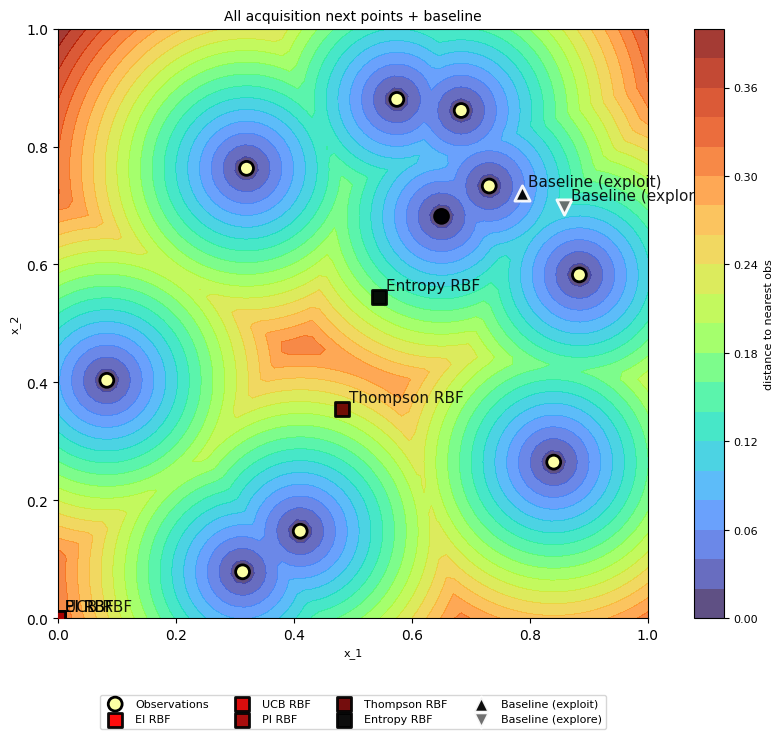

In [9]:
# PLOT ALL ACQUISITION FUNCTIONS + BASELINE (exploit / explore from cell above)

X_best_combined = np.array([x_best_EI_RBF, x_best_UCB_RBF, x_best_PI_RBF, x_thomson_RBF, x_entropy_RBF])
labels_combined = ['EI RBF','UCB RBF', 'PI RBF', 'Thompson RBF', 'Entropy RBF']
colors_combined = plt.cm.flag(np.linspace(0, 1, len(X_best_combined)))

fig, ax = plt.subplots(figsize=(10, 8))
cf = ax.contourf(X1g, X2g, min_dist, levels=22, cmap="turbo", alpha=0.8)
add_colorbar(cf, ax=ax, label="distance to nearest obs", font_size_axis=DEFAULT_FONT_SIZE_AXIS)
ax.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap="inferno", edgecolors="k", linewidths=2, zorder=5, label="Observations")
for i, (pt, lbl) in enumerate(zip(X_best_combined, labels_combined)):
    ax.scatter(pt[0], pt[1], c=[colors_combined[i]], s=100, marker='s', edgecolors="k", linewidths=2, zorder=10, alpha=0.95, label=lbl)
    ax.annotate(lbl, (pt[0], pt[1]), xytext=(5, 5), textcoords="offset points", fontsize=11, alpha=0.9, zorder=11)
# Baseline suggestions (from cell above: exploit = small step from best, explore = random in [0,1]²)
ax.scatter(next_x[0], next_x[1], c='k', s=120, marker='^', edgecolors='w', linewidths=2, zorder=10, alpha=0.95, label='Baseline (exploit)')
ax.annotate('Baseline (exploit)', (next_x[0], next_x[1]), xytext=(5, 5), textcoords="offset points", fontsize=11, alpha=0.9, zorder=11)
ax.scatter(next_x_explore[0], next_x_explore[1], c='dimgray', s=120, marker='v', edgecolors='w', linewidths=2, zorder=10, alpha=0.95, label='Baseline (explore)')
ax.annotate('Baseline (explore)', (next_x_explore[0], next_x_explore[1]), xytext=(5, 5), textcoords="offset points", fontsize=11, alpha=0.9, zorder=11)
style_axis(ax, xlabel="x_1", ylabel="x_2", title="All acquisition next points + baseline", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=DEFAULT_FONT_SIZE_AXIS, ncol=4, frameon=True)
ax.set_aspect("equal")
plt.tight_layout()
fig.subplots_adjust(bottom=0.22)
if IF_SHOW_PLOT:
    plt.show()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"function_1_all_acquisition_points.{DEFAULT_EXPORT_FORMAT}"
    fig.savefig(out_path, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path)

## 4. Illustrate the locations on the proposed query

## 4. Append new feedback (after portal returns)

After you submit and receive the new **(x, y)** from the portal for Function 1, paste the values below and run this cell. It appends the new point to a local dataset under `data/problems/function_1/`. The next time you run the notebook from the top, section 1 will load from this local dataset (initial + all appended points).

In [10]:
if not IF_APPEND_DATA:
    print("IF_APPEND_DATA is False; append skipped. Set IF_APPEND_DATA = True and paste portal feedback below to run.")
else:
    # Paths (use repo_root from setup cell)
    _local_dir = repo_root / "data" / "problems" / "function_1"
    assert_not_under_initial_data(_local_dir, project_root=repo_root)
    _local_inputs = _local_dir / "inputs.npy"
    _local_outputs = _local_dir / "outputs.npy"

    # Set these from the portal feedback for Function 1 (one new input and one new output)
    x_new = np.array([0.472352, 0.625531], dtype=np.float64)  # replace with your submitted input
    y_new = -1.802e-144  # replace with the output returned (scalar)

    # Load current data (local if exists, else initial_data)
    if _local_inputs.exists() and _local_outputs.exists():
        X_cur = np.load(_local_inputs)
        y_cur = np.load(_local_outputs)
        if y_cur.ndim > 1:
            y_cur = y_cur.squeeze()
    else:
        X_cur, y_cur = load_function_data(function_id=1)

    # Append: one new row for inputs, one new value for outputs
    x_new = np.atleast_2d(x_new)
    X_updated = np.vstack((X_cur, x_new))
    y_updated = np.append(y_cur, y_new)

    # Save to local directory (do not overwrite read-only initial_data)
    _local_dir.mkdir(parents=True, exist_ok=True)
    np.save(_local_dir / "inputs.npy", X_updated)
    np.save(_local_dir / "outputs.npy", y_updated)
    print("Appended. Total points:", len(y_updated))
    print("Saved to", _local_dir)

IF_APPEND_DATA is False; append skipped. Set IF_APPEND_DATA = True and paste portal feedback below to run.


## 5. Save suggestion for submission

Write the chosen x to `data/submissions/` so you can upload it to the portal. **Portal format:** `x1-x2-...-xn` with **exactly six decimal places**, values in [0, 0.999999], **hyphens only, no spaces** (e.g. `0.498317-0.625531`). After you receive the new y, run section 4 (Append new feedback) to add it to your dataset, then re-run the notebook for the next round.

In [11]:
if IF_EXPORT_QUERIES:
    # Portal format: each value 0.XXXXXX (exactly 6 decimals), in [0, 0.999999], hyphen-separated, no spaces
    next_x_clip = np.clip(np.asarray(next_x, dtype=np.float64).ravel(), 0.0, 0.999999)
    portal_str = "-".join(f"{v:.6f}" for v in next_x_clip)
    out_dir = repo_root / "data" / "submissions" / "function_1"
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir / "next_input.npy", next_x_clip)
    (out_dir / "next_input_portal.txt").write_text(portal_str)
    print("Saved to", out_dir / "next_input.npy")
    print("Portal string (copy-paste to portal):", portal_str)
    print("Also saved to", out_dir / "next_input_portal.txt")
else:
    print("IF_EXPORT_QUERIES is False; next_input.npy not saved.")

IF_EXPORT_QUERIES is False; next_input.npy not saved.
